<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/ARIMA_and_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import io
import requests
# lib to plot the data
import matplotlib.pyplot as plt
# lib to use the decompositio in the time series
from statsmodels.tsa.seasonal import seasonal_decompose
# lib to use the acf and pcf correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# lib to organize the data in data frame
from pandas import DataFrame
# lib to organize the time series by periods
from pandas import TimeGrouper

# lib to import the stocastic basic models
from statsmodels.tsa.api import Holt
# lib to import the ar model
from statsmodels.tsa.ar_model import AR

from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.metrics import mean_squared_error

# Constants

In [0]:
H = 6
V = 12

# Monthly Sunspots

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985)

## Data

In [3]:
url='https://raw.githubusercontent.com/jamissonfreitas/IN1167/master/monthly-sunspots.csv'
data = requests.get(url).content
data = data.decode('utf-8').replace("\"","").split('\n')
data = [d.strip().split(',') for d in data][1:-1]
data[:5]

[['1749-01', '58.0'],
 ['1749-02', '62.6'],
 ['1749-03', '70.0'],
 ['1749-04', '55.7'],
 ['1749-05', '85.0']]

In [4]:
df = pd.DataFrame(
    data, 
    columns=['Month', 'Sunspots']
) 
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m', errors='coerce')
df = df.set_index(df['Month'])
serie = df['Sunspots']
serie[:10]

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
1749-06-01    83.5
1749-07-01    94.8
1749-08-01    66.3
1749-09-01    75.9
1749-10-01    75.5
Name: Sunspots, dtype: object

## Plot Serie

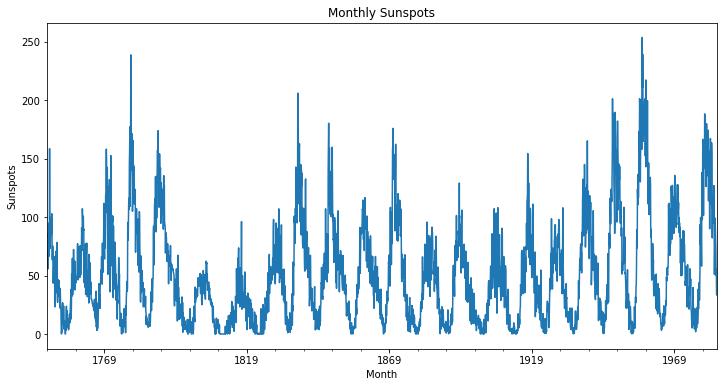

In [5]:
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.title('Monthly Sunspots')
plt.ylabel('Sunspots')
plt.xlabel('Month')
plt.show()

### Diff

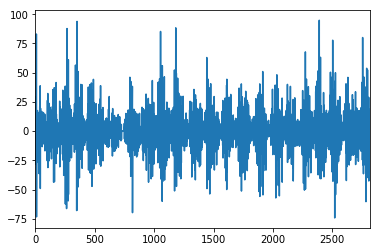

In [6]:
import numpy as np
s_diff = np.diff(serie)
s_diff = pd.Series(s_diff)
s_diff.plot()

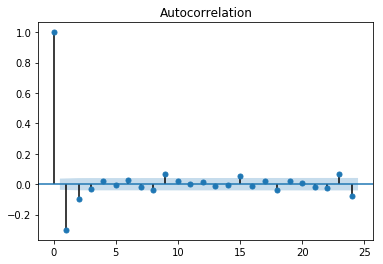

In [7]:
plot_acf(s_diff, lags=24)
plt.show()

## ACF

<Figure size 432x864 with 0 Axes>

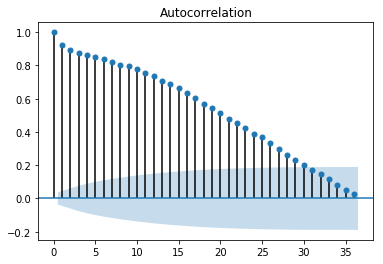

In [8]:
plt.figure(figsize=(H,V))
plot_acf(serie, lags=36)
plt.show()

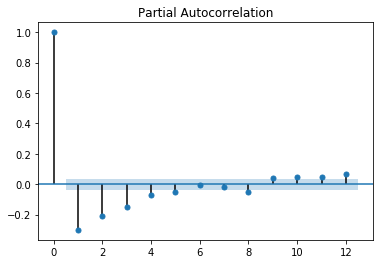

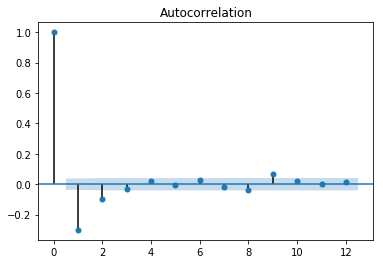

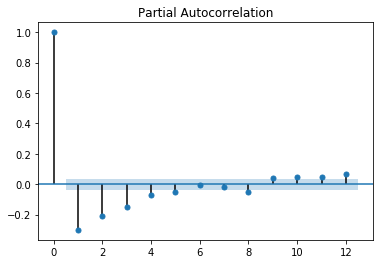

In [10]:
plot_acf(s_diff, lags=12)

plot_pacf(s_diff, lags=12)

## Seasonal decompose

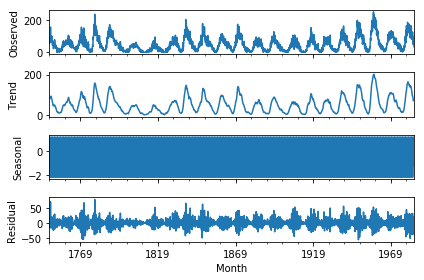

In [14]:
decompose = seasonal_decompose(serie, model='additive')
decompose.plot()
plt.show()

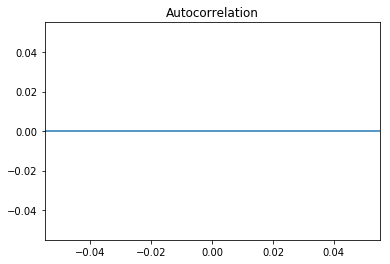

In [0]:
plot_acf(decompose.resid, lags=36)
plt.show()

## Data train and test

In [15]:
size = len(serie)
print(size)
l = int((7*size)/10)
print(l)

# original serie
serie_train = serie[:l]
serie_test = serie[l:]

size = len(s_diff)
print(size)
l = int((7*size)/10)
print(l)

# diff serie
s_diff_train = s_diff[:l]
s_diff_test = s_diff[l:]

2820
1974
2819
1973


## ARIMA

In [62]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARIMA(s_diff_train, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue
              
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: 16267.02061 | order: (3, 0, 2)


In [63]:
# train ARIMA
model = ARIMA(s_diff_train, order=(3, 0, 2))
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  3
parameters:  const     -0.032388
ar.L1.y   -0.771434
ar.L2.y    0.152674
ar.L3.y   -0.023775
ma.L1.y    0.322655
ma.L2.y   -0.610675
dtype: float64


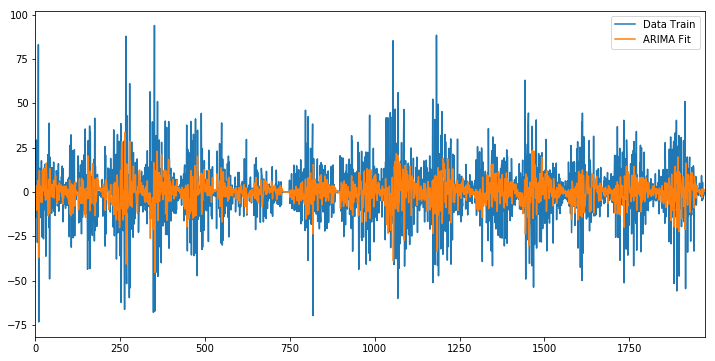

aic: 16318.25460
MSE =  505.24591908246003


In [86]:
plt.figure(figsize=(V,H))

# plot data train and test
s_diff_train.plot(label='Data Train')

#s_diff_test.plot(label='Data Test')

predict_train = model_fitted.predict(start=s_diff_train.index[0], end=len(s_diff_train), dynamic=False)
predict_train.plot(label='ARIMA Fit')

#predict = model_fitted.predict(start=s_diff_test.index[0], end=s_diff_test.index[-1], dynamic=False)
#predict.plot(label='ARIMA Forecasting')

#to show
plt.legend()
plt.show()

print('aic: {:6.5f}'.format(model_fitted.aic))

print('MSE = ', mean_squared_error(s_diff_train, predict_train[1:]))

In [105]:
print(model_fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1973
Model:                     ARMA(3, 2)   Log Likelihood               -8152.127
Method:                       css-mle   S.D. of innovations             15.072
Date:                Tue, 08 Oct 2019   AIC                          16318.255
Time:                        20:00:32   BIC                          16357.366
Sample:                             0   HQIC                         16332.625
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0324      0.147     -0.220      0.826      -0.321       0.256
ar.L1.y       -0.7714      0.078     -9.855      0.000      -0.925      -0.618
ar.L2.y        0.1527      0.062      2.459      0.0

### Residuo

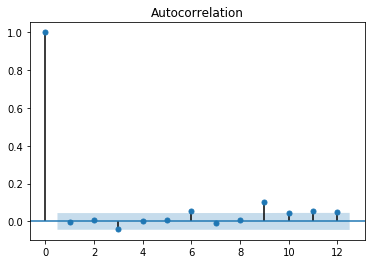

In [69]:
p = plot_acf(model_fitted.resid, lags=12)

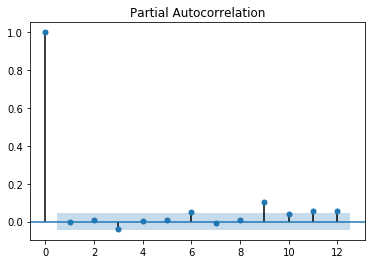

In [70]:
p = plot_pacf(model_fitted.resid, lags=12)

<Figure size 864x432 with 0 Axes>

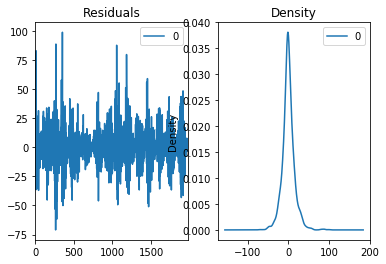

In [104]:
plt.figure(figsize=(V,H))

# Plot residual errors
residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()